# Projet de Machine Learning - M2 BIDABI

Ce projet vise √† d√©velopper un mod√®le de classification capable de d√©terminer le sentiment d‚Äôun tweet, qu‚Äôil soit positif ou n√©gatif, en utilisant le jeu de donn√©es Sentiment140, disponible sur Kaggle. 

### Chargement des librairies

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement de texte
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc



### 1. Chargement des donn√©es

Dans ce projet, nous utilisons le jeu de donn√©es Sentiment140 disponible sur Kaggle, qui contient 1,6 million de tweets √©tiquet√©s avec des sentiments positifs ou n√©gatifs.

In [2]:
import pandas as pd

df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None,
                 names=["sentiment", "ids", "date", "flag", "user", "text"], encoding='latin1')

df.head()

sentiment         ids                          date      flag  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [3]:
df.shape

(1600000, 6)

In [4]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [5]:
# S√©lection d‚Äôun √©chantillon
df = df.sample(n=80000, random_state=42).reset_index(drop=True)

### 2. Pr√©traitement des donn√©es

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))  # Vous pouvez ajouter des mots sp√©cifiques si besoin
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    # Convertir en minuscules
    tweet = tweet.lower()
    # Retirer les URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    # Retirer les mentions & hashtag
    tweet = re.sub(r'@\w+|#', '', tweet)
    # Retirer la ponctuation et les chiffres
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    # Tokenisation
    tokens = tweet.split()
    # Suppression des stopwords + lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Reconstruire la phrase nettoy√©e
    cleaned_tweet = " ".join(tokens)
    return cleaned_tweet


[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     Une connexion existante a d√ª √™tre ferm√©e par l‚Äôh√¥te
[nltk_data]     distant>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] Une
[nltk_data]     connexion existante a d√ª √™tre ferm√©e par l‚Äôh√¥te
[nltk_data]     distant>


In [7]:
df['clean_text'] = df['text'].apply(clean_tweet)

In [8]:
df.head()

sentiment         ids                          date      flag  \
0          0  2200003196  Tue Jun 16 18:18:12 PDT 2009  NO_QUERY   
1          0  1467998485  Mon Apr 06 23:11:14 PDT 2009  NO_QUERY   
2          0  2300048954  Tue Jun 23 13:40:11 PDT 2009  NO_QUERY   
3          0  1993474027  Mon Jun 01 10:26:07 PDT 2009  NO_QUERY   
4          0  2256550904  Sat Jun 20 12:56:51 PDT 2009  NO_QUERY   

              user                                               text  \
0  LaLaLindsey0609             @chrishasboobs AHHH I HOPE YOUR OK!!!    
1      sexygrneyes  @misstoriblack cool , i have no tweet apps  fo...   
2       sammydearr  @TiannaChaos i know  just family drama. its la...   
3      Lamb_Leanne  School email won't open  and I have geography ...   
4      yogicerdito                             upper airways problem    

                                          clean_text  
0                                       ahhh hope ok  
1                               cool tweet apps razr  
2  know family drama lamehey next time u hang kim...  
3  school email wont open geography stuff revise ...  
4                               upper airway problem

In [9]:
df['sentiment'].describe()

count    80000.000000
mean         2.000050
std          2.000012
min          0.000000
25%          0.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: sentiment, dtype: float64

In [10]:
df['sentiment'].nunique()

2

In [11]:
df['sentiment'].replace(4, 1, inplace=True) 

C:\Users\gueye\AppData\Local\Temp\ipykernel_29724\4253677064.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sentiment'].replace(4, 1, inplace=True)


In [12]:
df['sentiment'].describe()

count    80000.000000
mean         0.500012
std          0.500003
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: sentiment, dtype: float64

In [13]:
# Exemples de tweets
print("\nExemples de tweets positifs :")
print(df[df['sentiment'] == 1]['clean_text'].head(5))


Exemples de tweets positifs :
6                                      lunchdj come eat
9     thank glad like product review bit site enjoy ...
10               zach make pee sitting im grown gay man
11                            sum day one word kackered
12                               great mind think alike
Name: clean_text, dtype: object


In [14]:
print("\nExemples de tweets n√©gatifs :")
print(df[df['sentiment'] == 0]['clean_text'].head(5))


Exemples de tweets n√©gatifs :
0                                         ahhh hope ok
1                                 cool tweet apps razr
2    know family drama lamehey next time u hang kim...
3    school email wont open geography stuff revise ...
4                                 upper airway problem
Name: clean_text, dtype: object


####  WordCloud Pour comprendre le vocabulaire utilis√© dans les tweets.

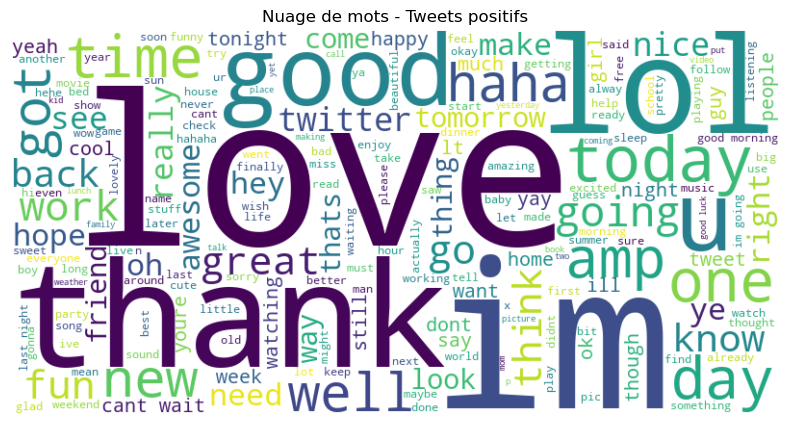

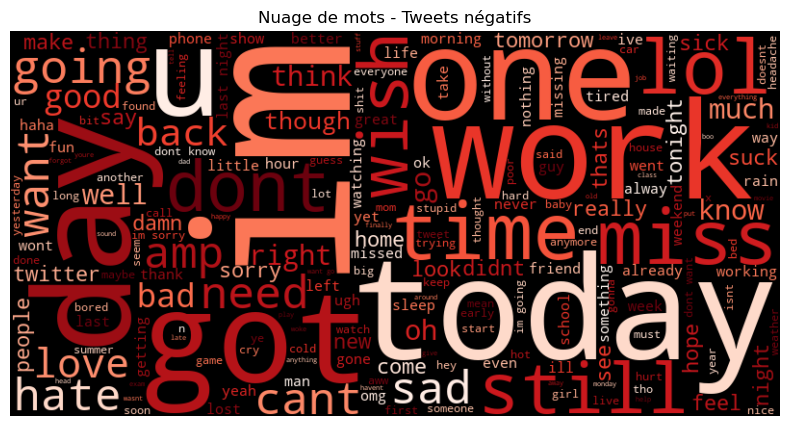

In [52]:
from wordcloud import WordCloud

# Tweets positifs
positive_text = " ".join(df[df["sentiment"] == 1]["clean_text"])
wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets positifs")
plt.show()

# Tweets n√©gatifs
negative_text = " ".join(df[df["sentiment"] == 0]["clean_text"])
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots - Tweets n√©gatifs")
plt.show()


### 3. Mod√©lisation

##### 3.1. Split en donn√©es d‚Äôentra√Ænement et de test

In [15]:
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
)


##### 3.2. Transformation en vecteurs

In [16]:
#  TF-IDF

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


##### 3.3. Mod√®le de regression logistique

In [17]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [18]:
# Pr√©dictions
y_pred_logistic = logistic_model.predict(X_test_tfidf)

In [19]:
# Calcul des m√©triques
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)

# Affichage des r√©sultats
print("Logistic Regression - Performances :")
print(f"Accuracy : {accuracy_logistic:.2f}")
print(f"Precision : {precision_logistic:.2f}")
print(f"Recall : {recall_logistic:.2f}")
print(f"F1-Score : {f1_logistic:.2f}\n")

Logistic Regression - Performances :
Accuracy : 0.77
Precision : 0.76
Recall : 0.78
F1-Score : 0.77



In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],  # Param√®tre de r√©gularisation
    'max_iter': [100, 200, 500]  # Nombre d'it√©rations pour la convergence
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)
print(f"Meilleurs param√®tres : {grid_search.best_params_}")


Meilleurs param√®tres : {'C': 1, 'max_iter': 100}


In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(), X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"Scores de cross-validation : {scores}")
print(f"Score moyen : {scores.mean()}")


Scores de cross-validation : [0.76765625 0.76132813 0.76015625 0.76734375 0.76609375]
Score moyen : 0.764515625


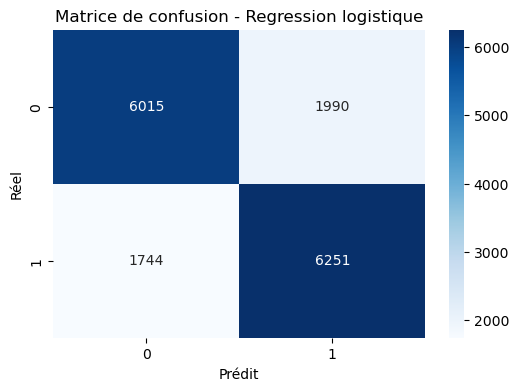

In [22]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_logistic)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matrice de confusion - Regression logistique')
plt.xlabel('Pr√©dit')
plt.ylabel('R√©el')
plt.show()


In [23]:
# Exemples de tweets pour test
test_tweets = [
    "I love the new design of the website! Great job üëè", 
    "This is the worst service I have ever experienced. I'm so disappointed.",
    "Not bad at all, but could have been better.",
    "I am so happy with my purchase! Highly recommend it.",
    "Terrible experience. I will never come back here again."
]

# Pr√©dictions pour Logistic Regression
print("\nPr√©dictions avec Logistic Regression (textes bruts) :\n")
for tweet in test_tweets:
    vectorized_tweet = tfidf.transform([tweet])  # Transformation TF-IDF sans nettoyage
    prediction = logistic_model.predict(vectorized_tweet)  # Pr√©diction
    sentiment = "Positif" if prediction[0] == 1 else "N√©gatif"
    print(f"Tweet : {tweet}\nSentiment pr√©dit : {sentiment}\n")


Pr√©dictions avec Logistic Regression (textes bruts) :

Tweet : I love the new design of the website! Great job üëè
Sentiment pr√©dit : Positif

Tweet : This is the worst service I have ever experienced. I'm so disappointed.
Sentiment pr√©dit : N√©gatif

Tweet : Not bad at all, but could have been better.
Sentiment pr√©dit : N√©gatif

Tweet : I am so happy with my purchase! Highly recommend it.
Sentiment pr√©dit : Positif

Tweet : Terrible experience. I will never come back here again.
Sentiment pr√©dit : N√©gatif



In [24]:
# Comparer les √©tiquettes r√©elles avec les pr√©dictions
incorrect_predictions = X_test[y_pred_logistic != y_test]
incorrect_labels = y_test[y_pred_logistic != y_test]
incorrect_texts = df.iloc[incorrect_predictions.index]['clean_text']  # Afficher les tweets mal classifi√©s

# Les √©tiquettes r√©elles et les pr√©dictions
incorrect_results = pd.DataFrame({
    'Tweet': incorrect_texts,
    'V√©rit√©': incorrect_labels,
    'Pr√©diction': y_pred_logistic[y_pred_logistic != y_test]
})

# Afficher les erreurs
print(incorrect_results.head(10))  # Afficher les 5 premi√®res erreurs


                                                   Tweet  V√©rit√©  Pr√©diction
74783  im going miss youu next yearr better come vall...       1           0
65509  bed school morning gym final tomorrow jogging ...       0           1
39859                                  yeah deserve face       0           1
58834  one month til smoking ban roughly one month si...       1           0
53519  watching rent broadway dvd close im goin get w...       0           1
51037  im going dye hair dark burgundyblack chop long...       1           0
52593  ya pretty boring pretty entertaining wasnt cu ...       0           1
41373                 tired tired thinking going sleep x       1           0
9918                                    news yet working       1           0
29166  give watching conan instead hope nothing overu...       0           1


##### 3.4. Mod√®le Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB

# Entra√Æner Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [26]:
# Pr√©dictions
y_pred_nb = naive_bayes_model.predict(X_test_tfidf)

In [36]:
# Calcul des m√©triques
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

# Affichage des r√©sultats
print("Naive Bayes - Performances :")
print(f"Accuracy : {accuracy_nb:.2f}")
print(f"Precision : {accuracy_nb:.2f}")
print(f"Recall : {accuracy_nb:.2f}")
print(f"F1-Score : {accuracy_nb:.2f}\n")

Naive Bayes - Performances :
Accuracy : 0.76
Precision : 0.76
Recall : 0.76
F1-Score : 0.76



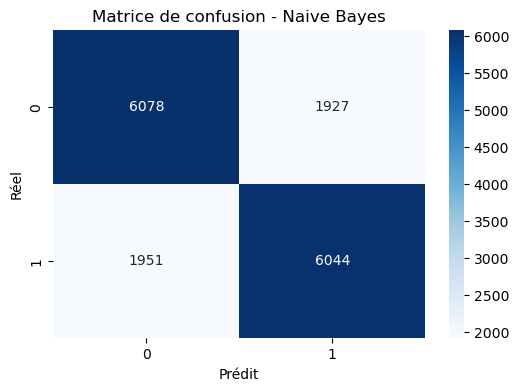

In [37]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matrice de confusion - Naive Bayes')
plt.xlabel('Pr√©dit')
plt.ylabel('R√©el')
plt.show()


In [29]:
# Pr√©dictions pour les tweets
print("\nPr√©dictions avec Naive Bayes :")
for tweet in test_tweets:
    vectorized_tweet = tfidf.transform([tweet])
    prediction = naive_bayes_model.predict(vectorized_tweet)
    sentiment = "Positif" if prediction[0] == 1 else "N√©gatif"
    print(f"Tweet : {tweet}\nSentiment pr√©dit : {sentiment}\n")


Pr√©dictions avec Naive Bayes :
Tweet : I love the new design of the website! Great job üëè
Sentiment pr√©dit : Positif

Tweet : This is the worst service I have ever experienced. I'm so disappointed.
Sentiment pr√©dit : N√©gatif

Tweet : Not bad at all, but could have been better.
Sentiment pr√©dit : N√©gatif

Tweet : I am so happy with my purchase! Highly recommend it.
Sentiment pr√©dit : Positif

Tweet : Terrible experience. I will never come back here again.
Sentiment pr√©dit : N√©gatif



##### 3.5. LinearSVC

In [30]:
from sklearn.svm import LinearSVC

# Entra√Æner le mod√®le
linear_svc_model = LinearSVC(max_iter=1000)
linear_svc_model.fit(X_train_tfidf, y_train)

c:\Users\gueye\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [31]:
# Pr√©dictions
y_pred_svc = linear_svc_model.predict(X_test_tfidf)

In [32]:
# Calcul des m√©triques
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)

# Affichage des r√©sultats
print("Linear SVC - Performances :")
print(f"Accuracy : {accuracy_svc:.2f}")
print(f"Precision : {precision_svc:.2f}")
print(f"Recall : {recall_svc:.2f}")
print(f"F1-Score : {f1_svc:.2f}\n")

Linear SVC - Performances :
Accuracy : 0.75
Precision : 0.75
Recall : 0.76
F1-Score : 0.76



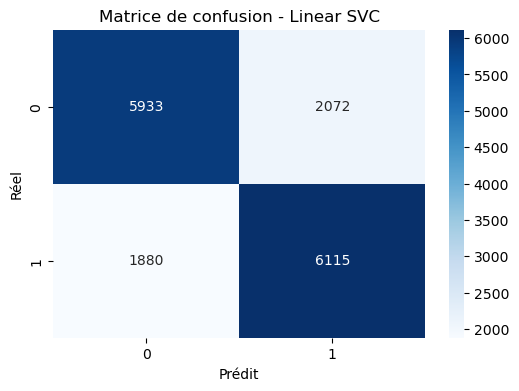

In [38]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matrice de confusion - Linear SVC')
plt.xlabel('Pr√©dit')
plt.ylabel('R√©el')
plt.show()


In [39]:
# Cr√©er un DataFrame pour stocker les performances
performance_data = {
    "Mod√®le": ["Logistic Regression", "Naive Bayes", "Linear SVC"],
    "Accuracy": [accuracy_logistic, accuracy_nb, accuracy_svc],
    "Precision": [precision_logistic, precision_nb, precision_svc],
    "Recall": [recall_logistic, recall_nb, recall_svc],
    "F1-Score": [f1_logistic, f1_nb, f1_svc]
}

performance_df = pd.DataFrame(performance_data)

# Affichage du tableau
print(performance_df)


                Mod√®le  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.766625   0.758524  0.781864  0.770017
1          Naive Bayes  0.757625   0.758249  0.755972  0.757109
2           Linear SVC  0.753000   0.746916  0.764853  0.755778


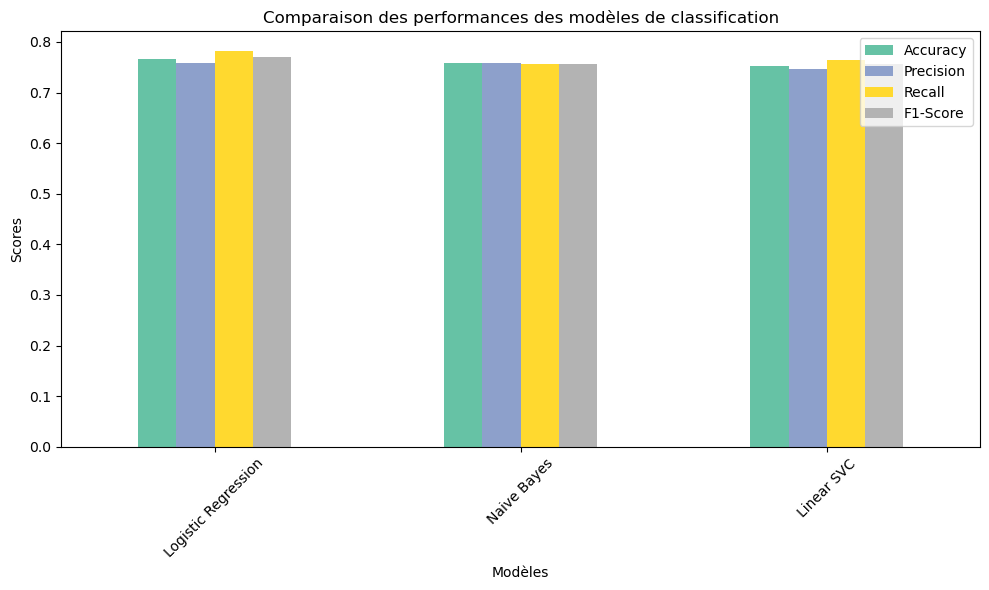

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cr√©er un DataFrame pour les performances des mod√®les
performance_data = {
    "Mod√®le": ["Logistic Regression", "Naive Bayes", "Linear SVC"],
    "Accuracy": [accuracy_logistic, accuracy_nb, accuracy_svc],
    "Precision": [precision_logistic, precision_nb, precision_svc],
    "Recall": [recall_logistic, recall_nb, recall_svc],
    "F1-Score": [f1_logistic, f1_nb, f1_svc]
}

performance_df = pd.DataFrame(performance_data)

# Transformation du DataFrame pour une meilleure gestion
performance_df = performance_df.set_index("Mod√®le")

# Tracer le graphique
plt.figure(figsize=(10, 6))

# Utilisation de seaborn pour dessiner un graphique √† barres
performance_df.plot(kind="bar", ax=plt.gca(), colormap="Set2")

# Ajouter des labels et un titre
plt.title("Comparaison des performances des mod√®les de classification")
plt.xlabel("Mod√®les")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.tight_layout()

# Affichage du graphique
plt.show()


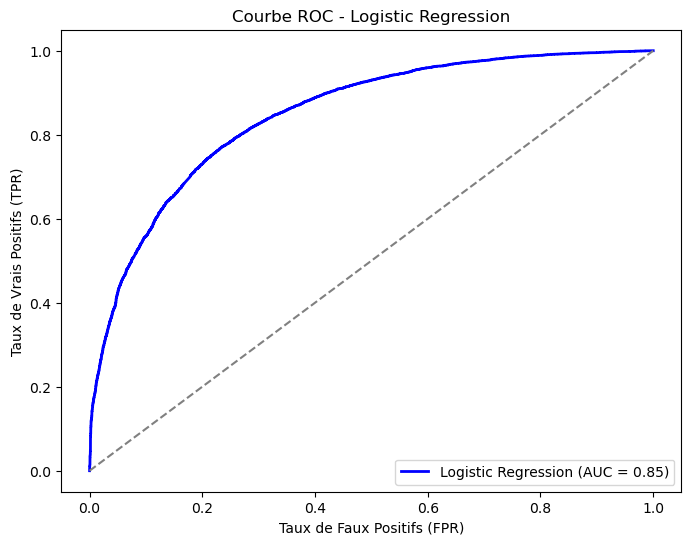

In [47]:
# Pr√©diction des probabilit√©s
y_scores_logistic = logistic_model.predict_proba(X_test_tfidf)[:, 1]

# Calcul des valeurs ROC
fpr, tpr, _ = roc_curve(y_test, y_scores_logistic)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de hasard
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


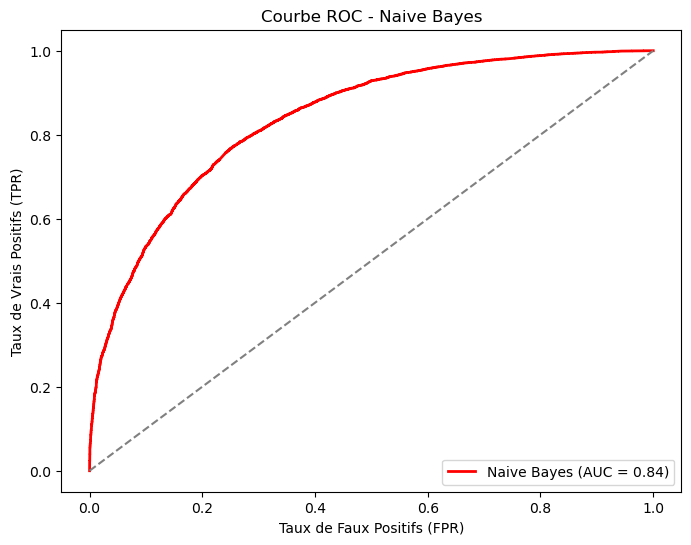

In [48]:
# Pr√©diction des probabilit√©s
y_scores_nb = naive_bayes_model.predict_proba(X_test_tfidf)[:, 1]

# Calcul des valeurs ROC
fpr, tpr, _ = roc_curve(y_test, y_scores_nb)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Naive Bayes (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC - Naive Bayes")
plt.legend(loc="lower right")
plt.show()


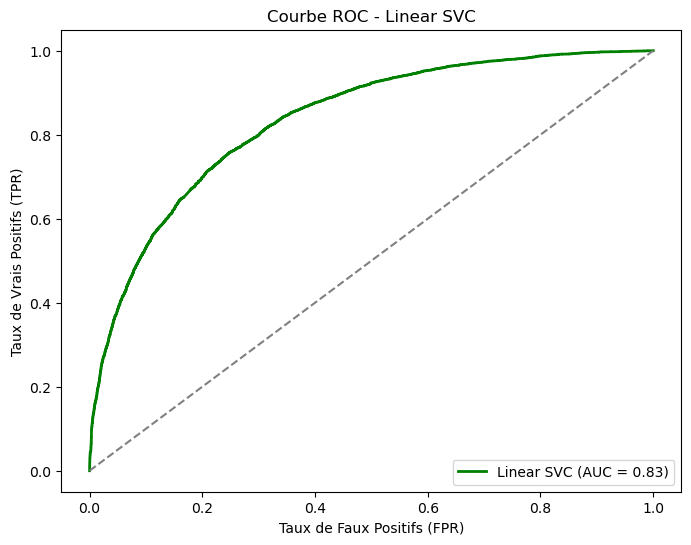

In [49]:
# Pr√©diction des scores
y_scores_svc = linear_svc_model.decision_function(X_test_tfidf)

# Calcul des valeurs ROC
fpr, tpr, _ = roc_curve(y_test, y_scores_svc)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'Linear SVC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC - Linear SVC")
plt.legend(loc="lower right")
plt.show()
